In [47]:
!pip install -U matplotlib

In [91]:
import toml
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pyspark
import dxpy
import dxdata
#import hail as hl

from pathlib import Path

In [2]:
with open("../config.toml") as f:
    conf = toml.load(f)

GENE = conf["GENE"]
#REFERENCE_GENOME = conf["REFERENCE_GENOME"]
#LOG_FILE = Path(conf["IMPORT"]["LOG_DIR"], f"{GENE}_results.log").resolve().__str__()

In [3]:
# Spark and Hail
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

#hl.init(sc=sc, default_reference=REFERENCE_GENOME, log=LOG_FILE)

In [14]:
def pval(x):
    if x < 0.0001:
        return "****"
    if x < 0.001:
        return "***"
    if x < 0.01:
        return "**"
    if x < 0.05:
        return "*"
    if x > 0.05:
        return ""
    
def pheno_search(x):
    try:
        return ukb_coding[ukb_coding.FieldID == int(x)].Field.values[0]
    except:
        # coding from https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=100605
        if x == "6150_1":
            return "Heart attack diagnosed by doctor"
        elif x == "6150_2":
            return "Angina diagnosed by doctor"
        elif x == "6150_3":
            return "Stroke diagnosed by doctor"
        elif x == "6150_4":
            return "High blood pressure diagnosed by doctor"
        elif x == "myo":
            return "myocardial disease incl. angina pectoris"
        elif x == "3005":
            return "Fracture resulting from simple fall"
        else:
            return x
        
def fix_df(df, TRAIT):
    if TRAIT == "BT":
        df["OR"] = np.exp(df.BETA)
        df["OR_upper"] = np.exp(df.BETA + df.SE)
        df["OR_lower"] = np.exp(df.BETA - df.SE)
        df["OR_se"] = df["OR_upper"] - df["OR_lower"]
    elif TRAIT == "QT":
        df.loc[:, "OR"] = df.BETA
        df.loc[:, "OR_se"] = df.SE

    df.loc[:, "Phenotype"] = df.PHENO.apply(lambda x: pheno_search(x))
    df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
    df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: pval(x))
    df.loc[:, "N_pos"] = (df["N"] * df["A1FREQ"]).astype(int)
    
    return df

In [9]:
files = [
    f"file:/mnt/project/data/results/{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/data/results/{GENE}")
]

ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/tmp/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

In [74]:
df = pd.read_csv(files[0], delimiter = " ", header = "infer", comment = "#").assign(SOURCE=os.path.basename(files[0]))
df = pd.concat([df] + [pd.read_csv(fp, delimiter = " ", comment = "#").assign(SOURCE=os.path.basename(fp)) for fp in files[1:]], axis = 0)

df.loc[:,"GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:,"MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:,"AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
df.loc[:,"FILE"] = df.SOURCE.apply(lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:])
df.loc[:,"TRAIT"] = df.FILE.apply(lambda x: x[0])
df.loc[:,"PHENO"] = df.FILE.apply(lambda x: x[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "FILE", "TEST"], axis = 1)
df.head()

,CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,N,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,SOURCE,GENE,MASK,AAF,FILE,TRAIT,PHENO
0,17,81809032,GCGR.WT.0.01,ref,WT.0.01,0.011657,154333,ADD,0.118580,0.056640,4.25547,1.40756,NaN,ukb_step2_BT_GCGR_130792.regenie,GCGR,WT,0.01,"[BT, GCGR, 130792.regenie]",BT,130792
1,17,81809032,GCGR.all_LOF.0.01,ref,all_LOF.0.01,0.000327,154333,ADD,0.691237,0.354208,3.80835,1.29245,NaN,ukb_step2_BT_GCGR_130792.regenie,GCGR,all_LOF,0.01,"[BT, GCGR, 130792.regenie]",BT,130792
2,17,81809032,GCGR.arr2_GOF.0.01,ref,arr2_GOF.0.01,0.000068,154333,ADD,1.323690,0.508310,5.57933,1.74056,NaN,ukb_step2_BT_GCGR_130792.regenie,GCGR,arr2_GOF,0.01,"[BT, GCGR, 130792.regenie]",BT,130792
0,17,81809032,GCGR.WT.0.01,ref,WT.0.01,0.011657,154333,ADD,0.079069,0.038695,4.14583,1.37948,NaN,ukb_step2_BT_GCGR_131286.regenie,GCGR,WT,0.01,"[BT, GCGR, 131286.regenie]",BT,131286
1,17,81809032,GCGR.all_LOF.0.01,ref,all_LOF.0.01,0.000327,154333,ADD,0.431902,0.226042,3.55771,1.22717,NaN,ukb_step2_BT_GCGR_131286.regenie,GCGR,all_LOF,0.01,"[BT, GCGR, 131286.regenie]",BT,131286


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

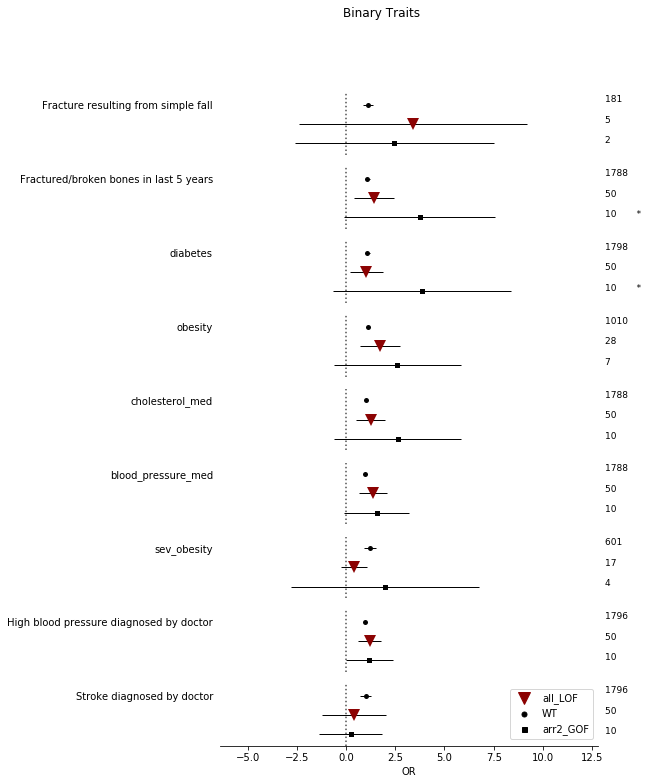

<Figure size 432x288 with 0 Axes>

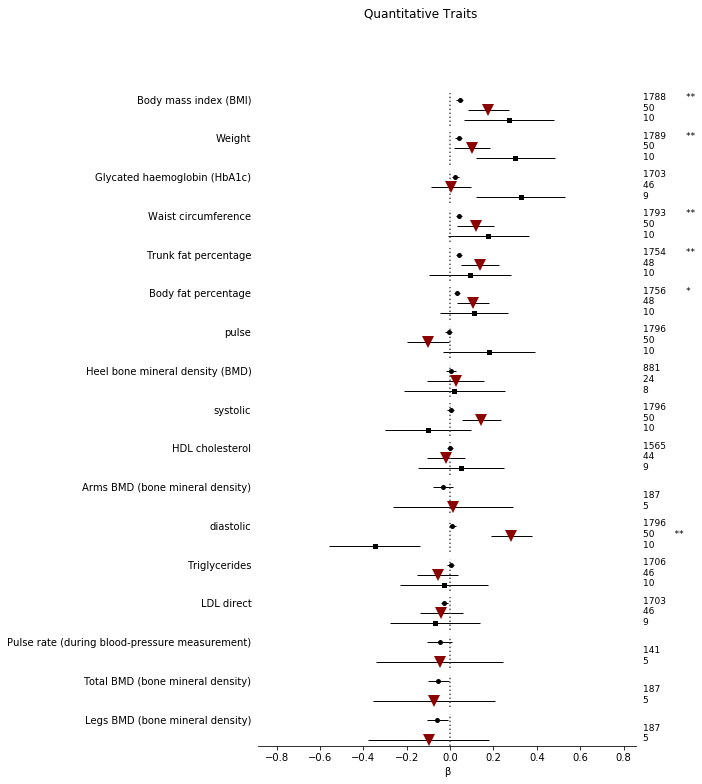

<Figure size 432x288 with 0 Axes>

In [110]:
TRAITS = ["BT", "QT"]
TITLES = ["Binary Traits", "Quantitative Traits"]
MASKS = df.MASK.unique()
MASKS[0], MASKS[1], MASKS[2] = MASKS[1], MASKS[2], MASKS[0]
XLAB = ["OR", "β"]

legend_elements = [Line2D([0], [0], color='darkred', marker="v", ms= 12, lw = 0, label='all_LOF'),
                  Line2D([0], [0], color='black', marker="o", ms=5, lw = 0, label='WT'),
                  Line2D([0], [0], color='black', marker="s", ms=5, lw = 0, label='arr2_GOF')]


for i, TRAIT in enumerate(TRAITS):
        
    df2 = df.loc[df.TRAIT == TRAIT,:]
    df2 = fix_df(df2, TRAIT=TRAIT)
    
    plt_df = (
    df2.loc[(df2.GENE == GENE)]
    .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
    .groupby(["Phenotype", "MASK"])
    .first()
    .reset_index()
    )

    plt_df = plt_df.loc[
        ~plt_df.Phenotype.isin(
            [
                # "sev_obesity",
                "Date E66 first reported (obesity)",
                "Date I10 first reported (essential (primary) hypertension)",
                "myocardial disease incl. angina pectoris",
                "Pulse rate, automated reading",
                "Heart attack diagnosed by doctor",
                "Angina diagnosed by doctor",
            ]
        )
    ]

    group_by_mean = pd.DataFrame(
        {"mean": plt_df.groupby(["Phenotype"]).agg("mean")["OR"]}
    ).reset_index()

    group_by_mean = group_by_mean.sort_values(
        by="mean", ascending=False
    ).reset_index()

    sorter = list(group_by_mean["Phenotype"])

    plt_df.loc[:,"Phenotype"] = plt_df.loc[:,"Phenotype"].astype("category")
    plt_df.loc[:,"Phenotype"].cat.set_categories(sorter, inplace=True)

    plt_df = plt_df.sort_values(
        by=["Phenotype", "MASK"], ascending=[True, False]
    ).reset_index(drop=True)
    
    phenotypes = plt_df.Phenotype.unique()
    
    fig, axes = plt.subplots(nrows=len(phenotypes), sharex=True, figsize=(6, 12))
    
    for ax in range(0, len(phenotypes)):
        temp = plt_df[plt_df.Phenotype == phenotypes[ax]]
        axes[ax].errorbar(
            temp[temp.MASK == MASKS[0]]["OR"],
            temp[temp.MASK == MASKS[0]].index,
            alpha=0.99,
            xerr=temp[temp.MASK == MASKS[0]]["OR_se"],
            fmt="v",
            c="darkred",
            ecolor="black",
            ms=12,
            mew=0.0,
            mec="black",
            elinewidth=1,
        )
        axes[ax].errorbar(
            temp[temp.MASK == MASKS[1]]["OR"],
            temp[temp.MASK == MASKS[1]].index,
            alpha=0.99,
            xerr=temp[temp.MASK == MASKS[1]]["OR_se"],
            fmt="s",
            c="black",
            ecolor="black",
            ms=5,
            mew=0.0,
            mec="black",
            elinewidth=1,
        )
        axes[ax].errorbar(
            temp[temp.MASK == MASKS[2]]["OR"],
            temp[temp.MASK == MASKS[2]].index,
            alpha=0.99,
            xerr=temp[temp.MASK == MASKS[2]]["OR_se"],
            fmt="o",
            c="black",
            ecolor="black",
            ms=5,
            mew=0.0,
            mec="black",
            elinewidth=1,
        )
        ax0 = axes[ax].twinx()
        ax0.set_ylim([0.25, 3.25])
        ax0.set_yticks([1, 2, 3])
        y2labels = (
            temp.N_pos.astype(str).values
            + len(temp.N_pos.astype(str).values) * ["       "]
            + temp.pval_stars.values
        )
        ax0.set_yticklabels(y2labels, fontsize=9)
        ax0.tick_params(right=False)
        ax0.spines["top"].set_alpha(0)
        ax0.spines["left"].set_alpha(0)
        ax0.spines["right"].set_alpha(0)
        ax0.spines["bottom"].set_alpha(0)
        ax0.grid(False)
        # axes[ax].invert_xaxis()
        # only show every 3rd yticklabel
        labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
        axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")
        # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
        axes[ax].tick_params(left=False)
        # axes[ax].set_xlim([-0.5, 0.5])
        axes[ax].spines["top"].set_alpha(0)
        axes[ax].spines["left"].set_alpha(0)
        axes[ax].spines["right"].set_alpha(0)
        if ax != len(phenotypes) - 1:
            axes[ax].spines["bottom"].set_alpha(0)
            axes[ax].tick_params(bottom=False)
        if (ax == len(phenotypes) - 1):
            axes[ax].set_xlabel(XLAB[i])
            if TRAIT == "BT":
                ax0.legend(handles = legend_elements, loc = "top right")
    # axes[len(phenotypes) - 1].set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])
    for ax in axes.flat:
        ax.margins(0.3)
    
    plt.subplots_adjust(right=1)
    fig.suptitle(TITLES[i])
    

    plt.show()
    plt.savefig(f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}.png", dpi = 600, bbox_inches="tight",)
    